In [135]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import tree 
import seaborn as sns
import sklearn 
import numpy as np  

In [136]:
avocado = pd.read_csv('HABdata_2019_2022.csv') # dataset downloaded directly from HAB
avocado_old = pd.read_csv('kaggledata_till2018.csv') # dataset downloaded from Kaggle
avocado = avocado.append(avocado_old, ignore_index=True)
avocado

,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69
...,...,...,...,...,...
6799,West,11/18/18,Organic,1.610000,334096.14
6800,West,11/25/18,Conventional,1.240000,3260102.17
6801,West,11/25/18,Organic,1.730000,268362.34
6802,West,12/2/18,Conventional,1.200000,4594863.86


## Prepare the Dataset

In [137]:
# Add the index for each year from 2015 through 2022
avocado['date'] = pd.to_datetime(avocado['date'])
avocado['year'] = pd.DatetimeIndex(avocado['date']).year
avocado['year_index'] = avocado['year'] - 2015
avocado = avocado.sort_values(by='date')

# Define the peak season
avocado['month'] = pd.DatetimeIndex(avocado['date']).month
peak_months = range(1,8)        # <--------- Set the months for the "peak season"
def peak_season(row):
    return 1 if int(row['month']) in peak_months else 0  

avocado['peak'] = avocado.apply(lambda row: peak_season(row), axis=1)

# Scale the number of avocados to millions
avocado['units_sold'] = avocado['units_sold']/1000000

# Select only conventional avocados
avocado = avocado[avocado['type'] == 'Conventional'] 

avocado = avocado[['date','units_sold','price','region','year','month','year_index','peak']].reset_index(drop = True)

avocado

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0,1
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0,1
2,2015-01-04,5.794411,0.890000,West,2015,1,0,1
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0,1
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0,1
...,...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,7,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,7,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,7,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,7,1


## Part 1: Observe Trends in the Data

Now, we will infer sales trends in time and seasonality. For simplicity, let's proceed with data from the United States as a whole.

In [138]:
df_Total_US = avocado[avocado['region']=='Total_US']

### Sales Over the Years

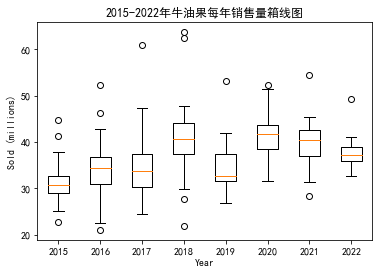

In [140]:
x1 = df_Total_US[df_Total_US['year']==2015]['units_sold'].values
x2 = df_Total_US[df_Total_US['year']==2016]['units_sold'].values
x3 = df_Total_US[df_Total_US['year']==2017]['units_sold'].values
x4 = df_Total_US[df_Total_US['year']==2018]['units_sold'].values
x5 = df_Total_US[df_Total_US['year']==2019]['units_sold'].values
x6 = df_Total_US[df_Total_US['year']==2020]['units_sold'].values
x7 = df_Total_US[df_Total_US['year']==2021]['units_sold'].values
x8 = df_Total_US[df_Total_US['year']==2022]['units_sold'].values

plt.title('2015-2022年牛油果每年销售量箱线图')

plt.boxplot((x1, x2, x3, x4, x5, x6, x7, x8), labels=('2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'))

plt.ylabel('Sold (millions)')
plt.xlabel('Year') 

plt.show()

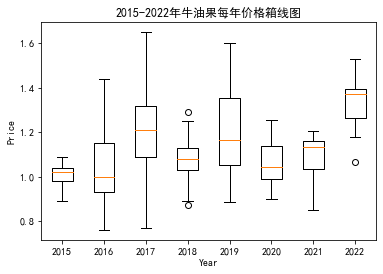

In [141]:
y1 = df_Total_US[df_Total_US['year']==2015]['price'].values
y2 = df_Total_US[df_Total_US['year']==2016]['price'].values
y3 = df_Total_US[df_Total_US['year']==2017]['price'].values
y4 = df_Total_US[df_Total_US['year']==2018]['price'].values
y5 = df_Total_US[df_Total_US['year']==2019]['price'].values
y6 = df_Total_US[df_Total_US['year']==2020]['price'].values
y7 = df_Total_US[df_Total_US['year']==2021]['price'].values
y8 = df_Total_US[df_Total_US['year']==2022]['price'].values

plt.title('2015-2022年牛油果每年价格箱线图')

plt.boxplot((y1, y2, y3, y4, y5, y6, y7, y8), labels=('2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'))

plt.ylabel('Price')
plt.xlabel('Year') 

plt.show()

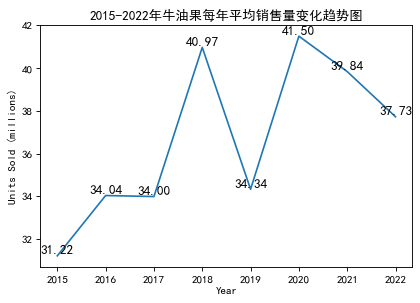

In [142]:
### 销售额随年的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 4), dpi=80)

y = df_Total_US.groupby('year')['units_sold'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('2015-2022年牛油果每年平均销售量变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Units Sold (millions)')
plt.xlabel('Year') 
 
plt.show()

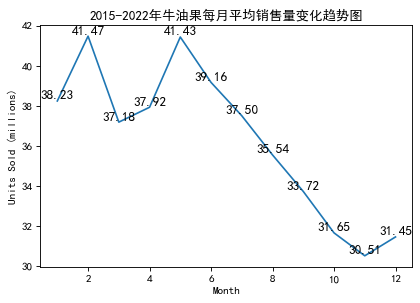

In [143]:
### 销售额随年的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 4), dpi=80)

y = df_Total_US.groupby('month')['units_sold'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('2015-2022年牛油果每月平均销售量变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Units Sold (millions)')
plt.xlabel('Month') 
 
plt.show()

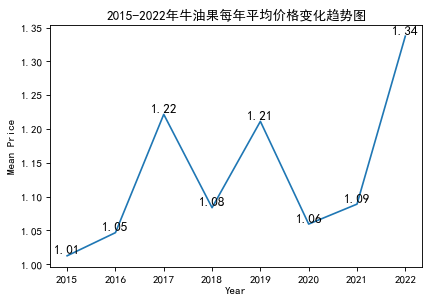

In [144]:
#每年平均价格的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 4), dpi=80)

y = df_Total_US.groupby('year')['price'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('2015-2022年牛油果每年平均价格变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Mean Price')
plt.xlabel('Year') 
 
plt.show()

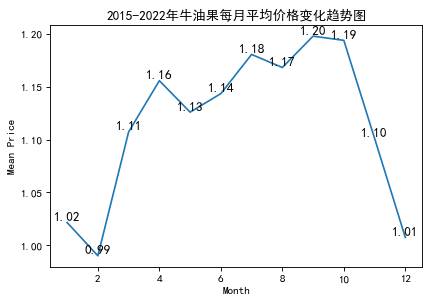

In [145]:
### 价格随月的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 4), dpi=80)

y = df_Total_US.groupby('month')['price'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('2015-2022年牛油果每月平均价格变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Mean Price')
plt.xlabel('Month') 
 
plt.show()

### Seasonality

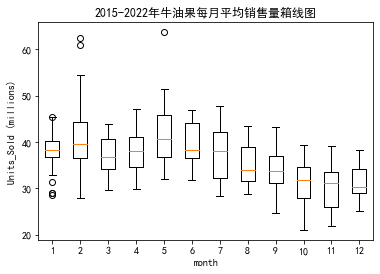

In [147]:
x1 = df_Total_US[df_Total_US['month']==1]['units_sold'].values
x2 = df_Total_US[df_Total_US['month']==2]['units_sold'].values
x3 = df_Total_US[df_Total_US['month']==3]['units_sold'].values
x4 = df_Total_US[df_Total_US['month']==4]['units_sold'].values
x5 = df_Total_US[df_Total_US['month']==5]['units_sold'].values
x6 = df_Total_US[df_Total_US['month']==6]['units_sold'].values
x7 = df_Total_US[df_Total_US['month']==7]['units_sold'].values
x8 = df_Total_US[df_Total_US['month']==8]['units_sold'].values
x9 = df_Total_US[df_Total_US['month']==9]['units_sold'].values
x10 = df_Total_US[df_Total_US['month']==10]['units_sold'].values
x11 = df_Total_US[df_Total_US['month']==11]['units_sold'].values
x12 = df_Total_US[df_Total_US['month']==12]['units_sold'].values

plt.title('2015-2022年牛油果每月平均销售量箱线图')

plt.boxplot((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12), labels=('1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12'))

plt.ylabel('Units_Sold (millions)')
plt.xlabel('month') 

plt.show()

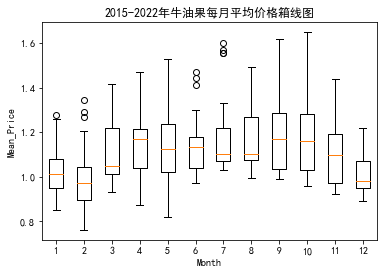

In [148]:
x1 = df_Total_US[df_Total_US['month']==1]['price'].values
x2 = df_Total_US[df_Total_US['month']==2]['price'].values
x3 = df_Total_US[df_Total_US['month']==3]['price'].values
x4 = df_Total_US[df_Total_US['month']==4]['price'].values
x5 = df_Total_US[df_Total_US['month']==5]['price'].values
x6 = df_Total_US[df_Total_US['month']==6]['price'].values
x7 = df_Total_US[df_Total_US['month']==7]['price'].values
x8 = df_Total_US[df_Total_US['month']==8]['price'].values
x9 = df_Total_US[df_Total_US['month']==9]['price'].values
x10 = df_Total_US[df_Total_US['month']==10]['price'].values
x11 = df_Total_US[df_Total_US['month']==11]['price'].values
x12 = df_Total_US[df_Total_US['month']==12]['price'].values

plt.title('2015-2022年牛油果每月平均价格箱线图')

plt.boxplot((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12), labels=('1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12'))

plt.ylabel('Mean_Price')
plt.xlabel('Month') 

plt.show()

We see a Super Bowl peak in February and a Cinco de Mayo peak in May. 

### Correlations

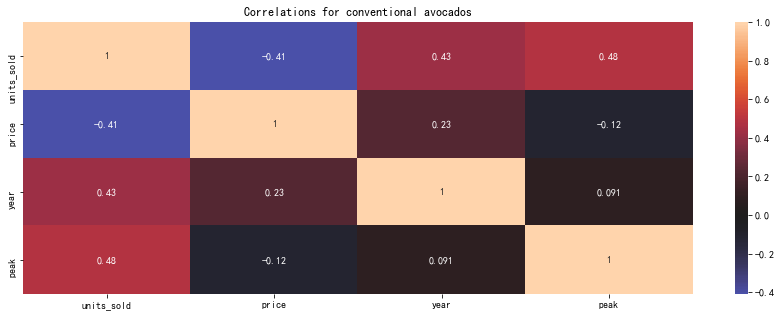

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5)) 
sns.heatmap(df_Total_US[['units_sold', 'price', 'year', 'peak']].corr(),annot=True, center=0,ax=axes) 

axes.set_title('Correlations for conventional avocados') 
plt.show()

### Regions

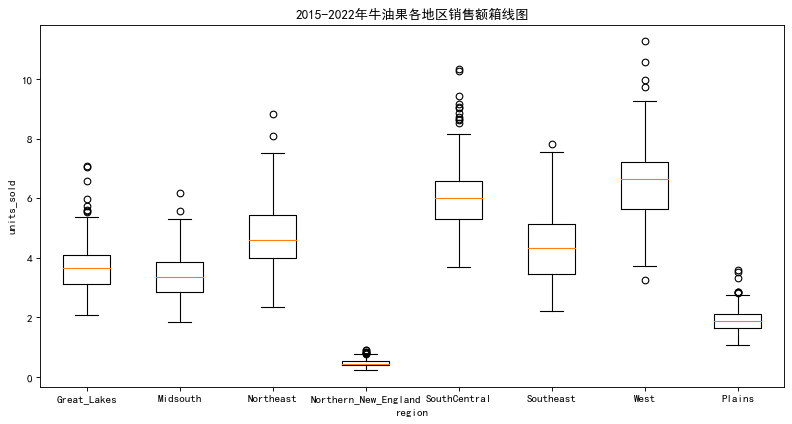

In [151]:
z1 = df[df['region']=='Great_Lakes']['units_sold']
z2 = df[df['region']=='Midsouth']['units_sold'].values
z3 = df[df['region']=='Northeast']['units_sold'].values
z4 = df[df['region']=='Northern_New_England']['units_sold'].values
z5 = df[df['region']=='SouthCentral']['units_sold'].values
z6 = df[df['region']=='Southeast']['units_sold'].values
z7 = df[df['region']=='West']['units_sold'].values
z8 = df[df['region']=='Plains']['units_sold'].values

plt.figure(figsize=(12, 6), dpi=80)
# 'Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains'
plt.title('2015-2022年牛油果各地区销售额箱线图')

plt.boxplot((z1, z2, z3, z4, z5, z6, z7, z8), labels=('Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains'))

plt.ylabel('units_sold')
plt.xlabel('region') 

plt.show()

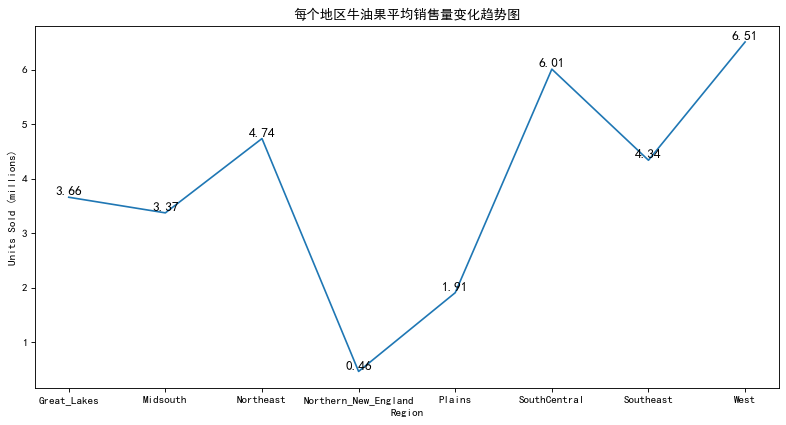

In [152]:
### 价格随月的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6), dpi=80)

y = df.groupby('region')['units_sold'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('每个地区牛油果平均销售量变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Units Sold (millions)')
plt.xlabel('Region') 
 
plt.show()

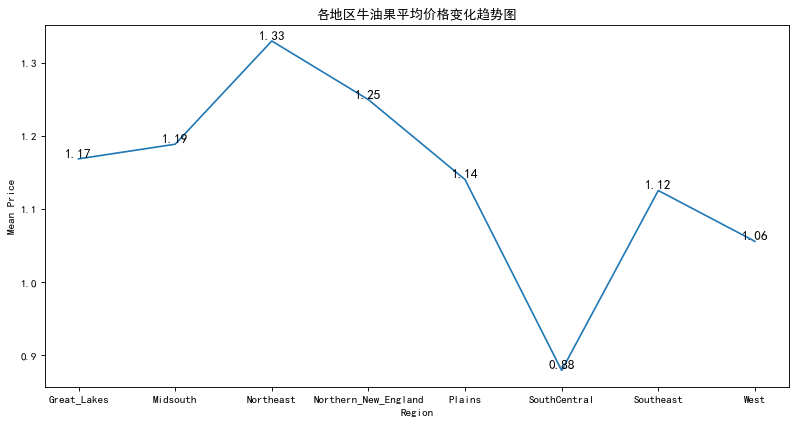

In [153]:
### 各地区价格的变化
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6), dpi=80)

y = df.groupby('region')['price'].mean()
x = y.index


plt.plot(x,y, mec='r', mfc='w')

#plt.legend()  # 让图例生效

plt.title('各地区牛油果平均价格变化趋势图')

for a,b in zip(x,y):
    plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=12)

#plt.xticks([int(i/90) for i in range(len(interaction_rate_mean.values))])

#plt.yticks([int(i/7) for i in range(len(amount_mean.values))]) 

plt.ylabel('Mean Price')
plt.xlabel('Region') 
 
plt.show()

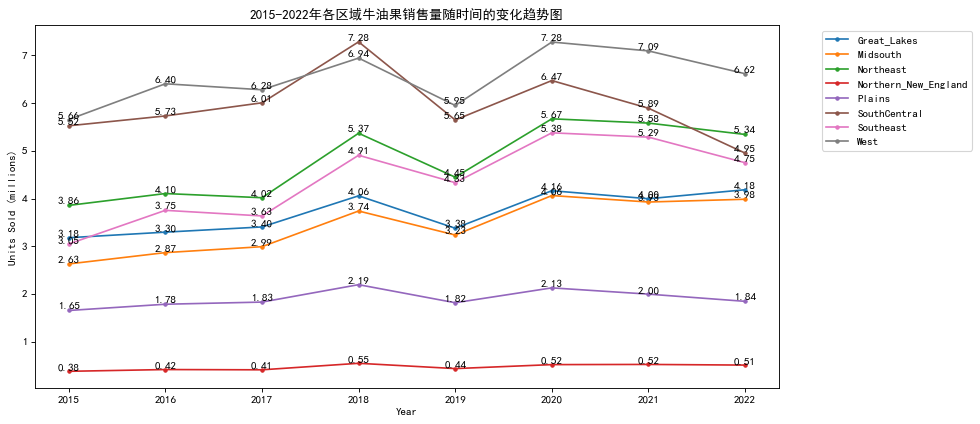

In [154]:
y1 = df[df['region']=='Great_Lakes'].groupby('year')['units_sold'].mean()
y2 = df[df['region']=='Midsouth'].groupby('year')['units_sold'].mean()
y3 = df[df['region']=='Northeast'].groupby('year')['units_sold'].mean()
y4 = df[df['region']=='Northern_New_England'].groupby('year')['units_sold'].mean()
y5 = df[df['region']=='Plains'].groupby('year')['units_sold'].mean()
y6 = df[df['region']=='SouthCentral'].groupby('year')['units_sold'].mean()
y7 = df[df['region']=='Southeast'].groupby('year')['units_sold'].mean()
y8 = df[df['region']=='West'].groupby('year')['units_sold'].mean()
x = y1.index

plt.figure(figsize=(12, 6), dpi=80)

plt.title('2015-2022年各区域牛油果销售量随时间的变化趋势图')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('Year')  # x轴标题
plt.ylabel('Units Sold (millions)')  # y轴标题
plt.plot(x, y1, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x, y2, marker='o', markersize=3)
plt.plot(x, y3, marker='o', markersize=3)
plt.plot(x, y4, marker='o', markersize=3)
plt.plot(x, y5, marker='o', markersize=3)
plt.plot(x, y6, marker='o', markersize=3)
plt.plot(x, y7, marker='o', markersize=3)
plt.plot(x, y8, marker='o', markersize=3)

 
for a, b in zip(x, y1):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)  # 设置数据标签位置及大小
for a, b in zip(x, y2):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y3):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y4):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y5):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y6):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y7):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y8):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
    
plt.legend(['Great_Lakes','Midsouth','Northeast','Northern_New_England','Plains','SouthCentral','Southeast','West'],bbox_to_anchor=(1.05,1))  # 设置折线名称
 
plt.show()  # 显示折线图


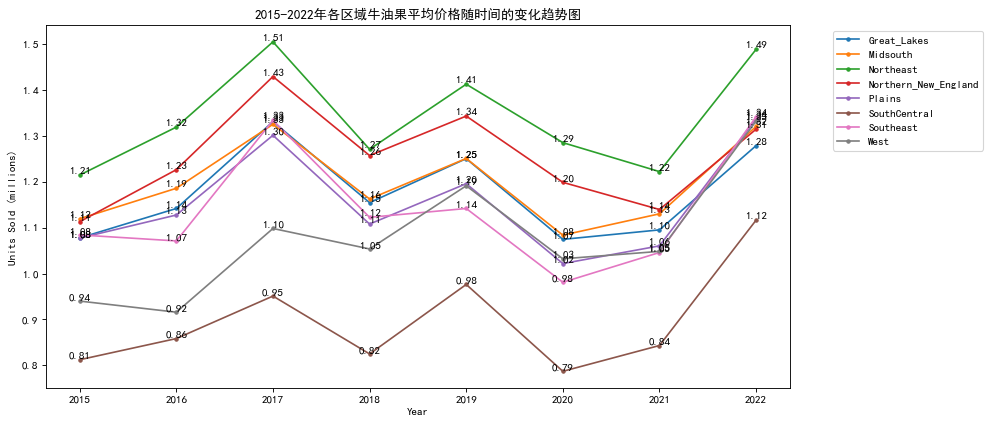

In [155]:
y1 = df[df['region']=='Great_Lakes'].groupby('year')['price'].mean()
y2 = df[df['region']=='Midsouth'].groupby('year')['price'].mean()
y3 = df[df['region']=='Northeast'].groupby('year')['price'].mean()
y4 = df[df['region']=='Northern_New_England'].groupby('year')['price'].mean()
y5 = df[df['region']=='Plains'].groupby('year')['price'].mean()
y6 = df[df['region']=='SouthCentral'].groupby('year')['price'].mean()
y7 = df[df['region']=='Southeast'].groupby('year')['price'].mean()
y8 = df[df['region']=='West'].groupby('year')['price'].mean()
x = y1.index

plt.figure(figsize=(12, 6), dpi=80)

plt.title('2015-2022年各区域牛油果平均价格随时间的变化趋势图')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('Year')  # x轴标题
plt.ylabel('Units Sold (millions)')  # y轴标题
plt.plot(x, y1, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x, y2, marker='o', markersize=3)
plt.plot(x, y3, marker='o', markersize=3)
plt.plot(x, y4, marker='o', markersize=3)
plt.plot(x, y5, marker='o', markersize=3)
plt.plot(x, y6, marker='o', markersize=3)
plt.plot(x, y7, marker='o', markersize=3)
plt.plot(x, y8, marker='o', markersize=3)

 
for a, b in zip(x, y1):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)  # 设置数据标签位置及大小
for a, b in zip(x, y2):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y3):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y4):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y5):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y6):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y7):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
for a, b in zip(x, y8):
    plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=10)
    
plt.legend(['Great_Lakes','Midsouth','Northeast','Northern_New_England','Plains','SouthCentral','Southeast','West'],bbox_to_anchor=(1.05,1))  # 设置折线名称
 
plt.show()  # 显示折线图


Clearly, west-coasters love avocados.

## Part II: Predict the Sales

$$demand = \beta_0 + \beta_1 * price + \sum\limits_{region} \beta^{region}_3 * \mathbb{1}(region)  +  \beta_4 w_{year}*year +  \beta_5  * \mathbb{1}(peak).$$ 

The R^2 value in the test set is 0.8966100355734138
The MSE value in the test set is 0.47067230738957283


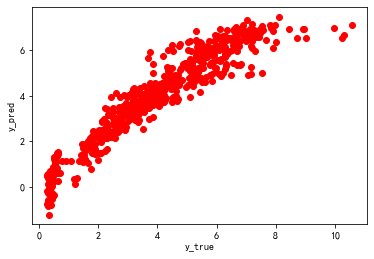

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             units_sold   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     2374.
Date:                Thu, 05 Jan 2023   Prob (F-statistic):               0.00
Time:                        22:18:44   Log-Likelihood:                -2283.4
No. Observations:                2419   AIC:                             4589.
Df Residuals:                    2408   BIC:                             4653.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             5.2316      0.094     55.634      0.000       5.047       5.416
C(region)[T.Midsouth]                -0.2288      0.050     -4.546      0.000      -0.327      -0.130
C(region)[T.Northeast]                1.3959      0.052     26.700      0.000       1.293       1.498
C(region)[T.Northern_New_England]    -3.0371      0.051    -59.537      0.000      -3.137      -2.937
C(region)[T.Plains]                  -1.8130      0.051    -35.829      0.000      -1.912      -1.714
C(region)[T.SouthCentral]             1.7654      0.055     32.208      0.000       1.658       1.873
C(region)[T.Southeast]                0.5885      0.050     11.671      0.000       0.490       0.687
C(region)[T.West]                     2.6051      0.052     50.536      0.000       2.504       2.706
price                                -2.0408      0.072    -28.455      0.000      -2.181      -1.900
year_index                            0.1519      0.006     25.599      0.000       0.140       0.163
peak                                  0.5314      0.026     20.213      0.000       0.480       0.583
==============================================================================
Omnibus:                      276.202   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.564
Skew:                           0.612   Prob(JB):                    5.24e-170
Kurtosis:                       5.497   Cond. No.                         40.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# Split the data for training and testing
train, test = train_test_split(df, train_size=0.8, random_state=1)
df_train = pd.DataFrame(train, columns=df.columns)
df_test = pd.DataFrame(test, columns=df.columns)
 
# Train the model
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod = smf.ols(formula,data=df_train)
result = mod.fit()
result.summary()

# Get R^2 from test data
y_true = df_test['units_sold']
y_pred = result.predict(df_test)
print("The R^2 value in the test set is",r2_score(y_true, y_pred))

#MSE
mse = np.sum((y_pred-y_true)**2)/len(y_true)
print("The MSE value in the test set is",mse)

plt.scatter(y_true, y_pred,c='r')#原始的数据 蓝色

#plt.title('线性回归模型预测值与真实值散点图')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('y_true')  # x轴标题
plt.ylabel('y_pred')  # y轴标题
#plt.plot(y_true, y_pred, color='red',alpha=0.6, linewidth=3,label='Predicted Line')
plt.show()

result.summary()

In [157]:
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod_full = smf.ols(formula,data=df)
result_full = mod_full.fit()

y_true_full = df['units_sold']
y_pred_full = result_full.predict(df)
print("The R^2 value in the full dataset is",r2_score(y_true_full, y_pred_full))

# Get the weights and store it
coef_dict = result_full.params.to_dict() 
coef_dict['C(region)[T.Great_Lakes]'] = 0 

The R^2 value in the full dataset is 0.9055930586793712


## Part III: Optimize for Price and Supply of Avocados

In [158]:
import gurobipy as gp 
from gurobipy import GRB

m = gp.Model("Avocado_Price_Allocation")

# Sets and parameters
R = regions   # set of all regions

B = 30  # total amount ot avocado supply

peak_or_not = 1 # 1 if it is the peak season; 1 if isn't
year = 2022

c_waste = 0.1 # the cost ($) of wasting an avocado
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}
# the cost of transporting an avocado

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked 
a_min = {r: 0 for r in R} # minimum avocado price in each region 
a_max = {r: 2 for r in R} # maximum avocado price in each region 
b_min = dict(df.groupby('region')['units_sold'].min())  # minimum number of avocados allocated to each region
b_max = dict(df.groupby('region')['units_sold'].max())   # maximum number of avocados allocated to each region

In [159]:
p = m.addVars(R,name="p",lb=a_min, ub=a_max)   # price of avocados in each region
x = m.addVars(R,name="x",lb=b_min,ub=b_max)  # quantity supplied to each region
s = m.addVars(R,name="s",lb=0)   # predicted amount of sales in each region for the given price
w = m.addVars(R,name="w",lb=0)   # excess wasteage in each region

In [160]:
d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}
for r in R:
    print(d[r])

<gurobi.LinExpr: 6.853384484787638 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 6.6074842569414605 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 8.260554380686084 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 3.8211615560475596 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 8.61359578005997 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 7.444320674114997 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 9.473274329722827 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>
<gurobi.LinExpr: 5.042895474480315 + -2.0435545971002744 <gurobi.Var *Awaiting Model Update*>>


In [161]:
m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R)) 
m.ModelSense = GRB.MAXIMIZE

In [162]:
m.addConstr(sum(x[r] for r in R) == B)
m.update()

In [163]:
m.addConstrs((s[r] <= x[r] for r in R))
m.addConstrs((s[r] <= d[r] for r in R)) 
m.update()

In [164]:
m.addConstrs((w[r] == x[r]-s[r] for r in R))
m.update()

In [165]:
m.Params.NonConvex = 2 
m.optimize() 

Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 25 rows, 32 columns and 64 nonzeros
Model fingerprint: 0x9fffe09f
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 1e+01]
  RHS range        [4e+00, 3e+01]

Continuous model is non-convex -- solving as a MIP

Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 34 rows, 33 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 0 integer (0 binary)

Root relaxation: objective 5.286357e+01, 36 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   52.8

In [166]:
solution = pd.DataFrame() 
solution['Region'] = R
solution['Price'] = [p[r].X for r in R]
solution['Allocated'] = [round(x[r].X,8) for r in R]
solution['Sold'] = [round(s[r].X,8) for r in R]
solution['Wasted'] = [round(w[r].X,8) for r in R]  
solution['Pred_demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million"%opt_revenue) 
solution


 The optimal net revenue: $42.889234 million


,Region,Price,Allocated,Sold,Wasted,Pred_demand
0,Great_Lakes,1.726829,3.324515,3.324515,1.000000e-08,3.324515
1,Midsouth,1.566664,5.427796,3.405920,2.021877e+00,3.405920
2,Northeast,2.000000,4.173445,4.173445,0.000000e+00,4.173445
3,Northern_New_England,1.420651,0.917984,0.917984,0.000000e+00,0.917984
4,SouthCentral,2.000000,4.526487,4.526487,1.000000e-08,4.526487
5,Southeast,1.821415,3.722160,3.722160,2.000000e-08,3.722160
6,West,2.000000,5.386165,5.386165,2.000000e-08,5.386165
7,Plains,1.233854,2.521448,2.521448,2.000000e-08,2.521448


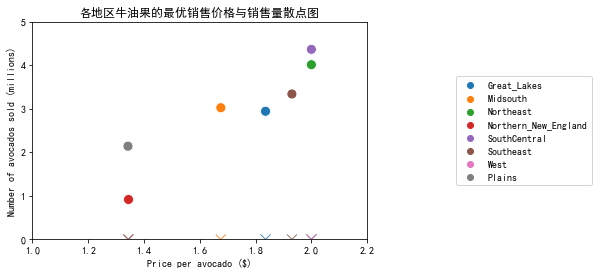

The circles represent sales quantity and the cross markers represent the wasted quantity.


In [169]:
fig, ax = plt.subplots(1,1) 
plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0, 5)
plt.xlim(1, 2.2)
plt.title('各地区牛油果的最优销售价格与销售量散点图')
ax.set_xlabel('Price per avocado ($)')
ax.set_ylabel('Number of avocados sold (millions)')
plt.show() 
print("The circles represent sales quantity and the cross markers represent the wasted quantity.")

In [168]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 
 
import plotly.express as px

peak_or_not = 1 # 
year = 2021

# Sets and parameters
R = regions  
c_waste = 0.1 
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}

# Get the lower and upper bounds for price (p) and amount to be stocked (x) from the dataset
price_min = dict(df.groupby('region')['price'].min())
price_max = dict(df.groupby('region')['price'].max())
sold_min = dict(df.groupby('region')['units_sold'].min()) 
sold_max = dict(df.groupby('region')['units_sold'].max())   



def solve_MIQP(x):
    B = x
    
    # Initialize Model
    m = gp.Model("Avocado_Price_Allocation")

    # Variables. Adjust the bounds here 
    x = m.addVars(R,name="x",lb=sold_min,ub=sold_max) 
    p = m.addVars(R,name="p",lb=0, ub=2)   
    s = m.addVars(R,name="s",lb=0)  
    w = m.addVars(R,name="w",lb=0) 
    i = m.addVars(R,name="i",vtype=GRB.BINARY) 

    # Predictor expression for demand
    d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}
 
    
    # Set the objective
    m.ModelSense = GRB.MAXIMIZE
    m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R)) 

    # Add the constraints 
    m.addConstrs((s[r] <= x[r] for r in R))
    m.addConstrs((s[r] <= d[r] for r in R)) 
    m.addConstrs((x[r] == w[r]+s[r] for r in R))
    m.addConstr(sum(x[r] for r in R) == B)

    # Solve   
    m.setParam('OutputFlag', 0)
    m.Params.NonConvex = 2
    m.update()
    m.optimize() 
    if m.status == 4:
        print('The problem is infeasible. Try changing the parameter values.')
    else:
        global solution, opt_revenue
        solution = pd.DataFrame() 
        solution['Region'] = R
        solution['Price'] = [p[r].X for r in R]
        solution['Allocated'] = [round(x[r].X,8) for r in R]
        solution['Sold'] = [round(s[r].X,8) for r in R]
        solution['Wasted'] = [round(w[r].X,8) for r in R]  
        solution['Demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

        opt_revenue = m.ObjVal
        if display_figures:
            print("\n Net revenue: $%f million"%opt_revenue)
            print("\nThe optimal solution is as follows. Price per avocado in dollars. Allocated avocados, wasted avocados, and predicted demand in millions.\n")
            print(solution)
            
            print("\n Scatter plot of price vs number of avocados sold (millions) for the eight regions:")
            fig, ax = plt.subplots(1,1) 
            plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
            plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

            plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plt.ylim(0, 5)
            plt.xlim(1, 2.2)
            ax.set_xlabel('Price per avocado ($)')
            ax.set_ylabel('Number of avocados sold (millions)')
            plt.show() 
            print("The circles represent sales quantity and the cross markers represent the wasted quantity.")
            
            
        return m.ObjVal, solution
        
        
display_figures = 1
print("Select a value for the available inventory (B) (in millions):\n")
interact(solve_MIQP, x=(15,40,1))



Select a value for the available inventory (B) (in millions):



interactive(children=(IntSlider(value=27, description='x', max=40, min=15), Output()), _dom_classes=('widget-i…

<function __main__.solve_MIQP(x)>